# Свёртка

Информация, которую можно было бы использовать в моделях, бывает очень разной. Например, в модель спокойно можно добавить фичи, созданные на основе фоток. Обычно это делается с помощью нейронок. Именно этим мы и займёмся. Однако для начала давайте немного поработаем с фотками. 

Для работы с фото мы будем использовать пакет `cv2`. Для его установки нужно прописать в консоли `pip3 install opencv-python`.  Для него написана довольно хорошая и понятная [документация.](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) 

In [2]:
import numpy as np     # Пакет для работы с векторами и матрицами
import urllib          # Пакет для чтения ссылок
   
import cv2 # Пакет для работы с фоточками 

from matplotlib import pyplot as plt  # Графики 
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

## 1. Слово о тензорах и картинках

Подгрузим какую-нибудь фотографию.

In [1]:
# Загружаем картинку
# 0 - подгрузка матрицы яркостей
# 1 - подгрузка матрицы из RGB-троек

def url_to_image(url):
    resp = urllib.request.urlopen(url)                        # Открываем фото
    image = np.asarray(bytearray(resp.read()), dtype="uint8") # Распаковываем его в матрицу
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # Конвертируем в формат для нашего пакета   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)            # Выбираем нужную цветовую схему 
    return image

# Загружаем фотку и смотрим как она выглядит 
img = url_to_image('https://www.mirf.ru/wp-content/uploads/2017/01/Drakarys.jpg')

plt.figure(figsize = (12,8))
plt.imshow(img)
plt.axis("off")

NameError: name 'urllib' is not defined

Отлично, фото в наших руках. На самом деле каждая картинка это набор пикселей. Если мы попросим питон показать нам картинку, он покажет матрицу из чисел.  Каждому пикселю в этой матрице соответствует число. Это число сообщает нам о том насколько этот пиксель яркий. Яркость измеряется по шкале от $0$ до $255$.

In [3]:
img[0][:5]  # цвета верхник пикселей по шкале RGB

array([[62, 36,  9],
       [62, 36,  9],
       [61, 35,  8],
       [59, 33,  6],
       [57, 31,  4]], dtype=uint8)

In [5]:
img[2]

array([[62, 36,  9],
       [60, 34,  7],
       [57, 31,  4],
       ...,
       [50, 38, 14],
       [49, 37, 13],
       [48, 36, 12]], dtype=uint8)

Цветные картинки представляются в виде [тензора,](https://www.wikiwand.com/ru/%D0%A2%D0%B5%D0%BD%D0%B7%D0%BE%D1%80) то есть матрицы из матриц. Любой цвет можно получить, смешав в какой-то пропорции красный, зелёный и синий цвета. В связи с этим каждый пиксель обычно характеризуют тремя цифрами: (насколько пиксель красный, насколько пиксель зелёный, насколько пиксель синий). Такой формат хранения картинки называется [RGB-форматом.](https://www.wikiwand.com/ru/RGB)

In [6]:
# Видим, что у нас картинка размера 87 на 130 пикселей и описывается 3 матрицами (одна на каждый цвет)
img.shape 

(1080, 1920, 3)

Все действия по редактированию картинки сводятся к математике. Чтобы осветлить картинку, нужно прибавить к каждому пикселю какое-то число. Для этого используют функцию `cv2.add`. В случае прибавления очень большого числа, она накопит яркость 255 и не пробьёт этот порог. Мы добвим 30 пунктов только к красной координате. Если захочется добавить 30 пунктов ко всем трём координатам, rкод придётся немнго модернизировать. 

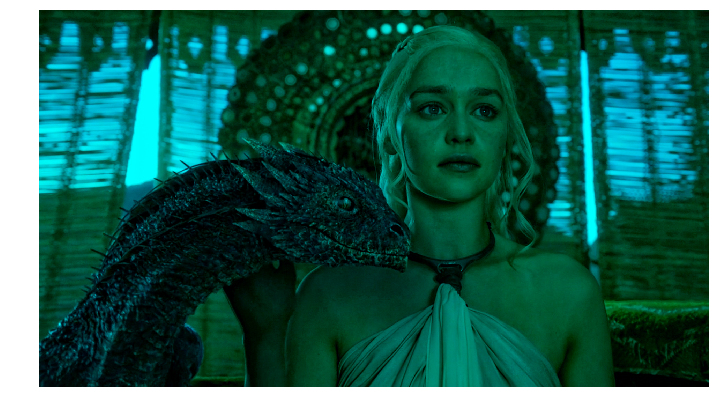

In [9]:
img_1 = cv2.add(img,-300)

plt.figure(figsize = (12,8))
plt.imshow(img_1)
plt.axis("off")
plt.show()

Умножение каждого пикселя на какое-то число увеличит контраст. Также проделаем этот фокус только с красной координатой. 

(-0.5, 1919.5, 1079.5, -0.5)

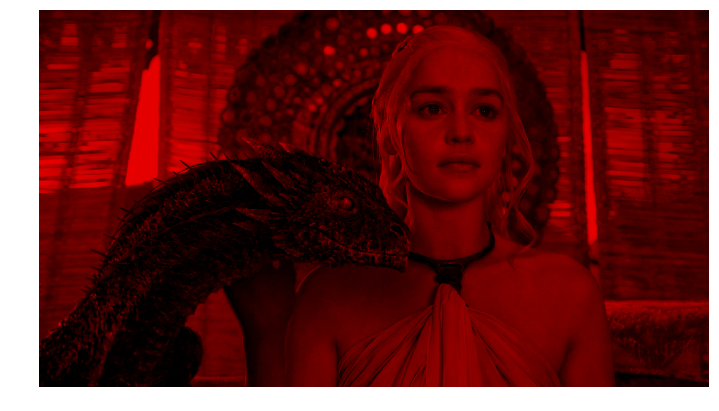

In [10]:
img_1 = cv2.multiply(img,0.9) # повышаем контраст

plt.figure(figsize = (12,8))
plt.imshow(img_1)
plt.axis("off")

Можно посмотреть на то как распределены на картинке пиксели различной яркости.

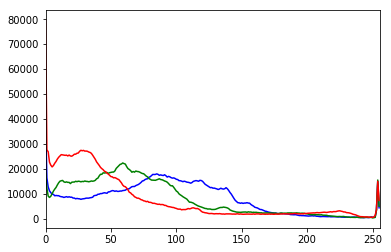

In [11]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

## 2. Эквилизация гистограммы

Изобразим гистограмму картинки и эмпирическую функцию распределения яркости пикселя.

Наши пиксели, на представленной ниже картинке сосредочены по своей яркости на определённом промежутке. Из-за этого мы не можем чётко выделить объекты на картинке. Если мы растянем пиксели по яркости в разные углы интервала, объекты начнут выделяться более чётко. В этом состоит смысл эквилизации. В ходе этого растягивания эмпирическая функция распределеия станет прямой. 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

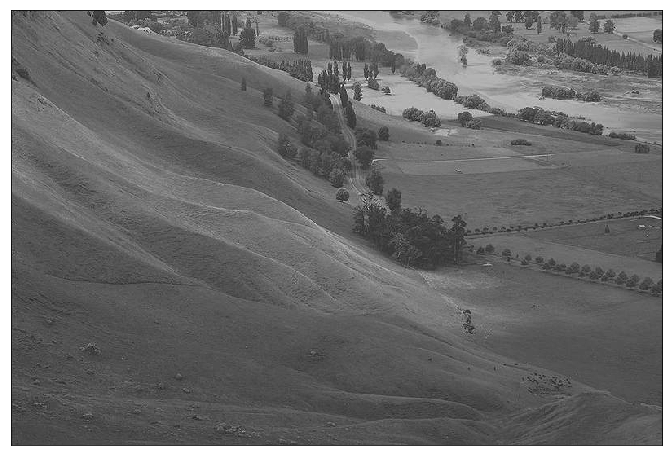

In [12]:
img = cv2.imread('forest.jpg',0)

plt.figure(figsize = (12,8))
plt.imshow(img,cmap='gray')
plt.xticks([]), plt.yticks([])

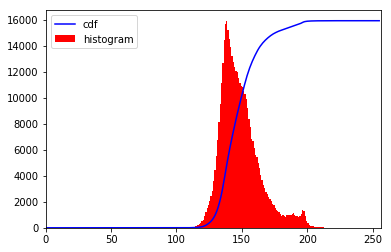

In [13]:
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

Прделаем эквилизацию. 

In [14]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img2 = cdf[img]

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

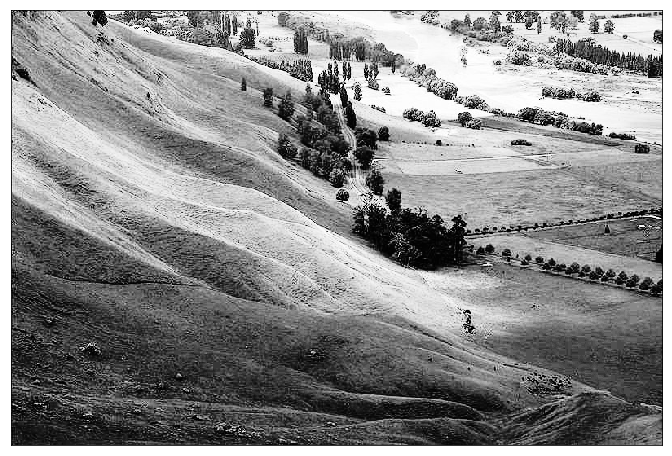

In [15]:
plt.figure(figsize = (12,8))
plt.imshow(img2,cmap='gray')
plt.xticks([]), plt.yticks([])

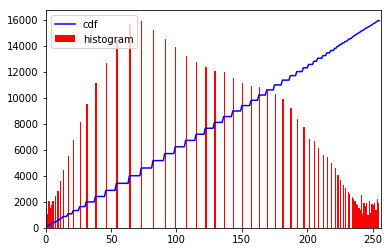

In [16]:
hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

Контраст на изображении стал виден более чётко. Гистограмма растянулась по яркости на весь диапозон. Внутри пакета есть более удобная для эквилизации функция.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

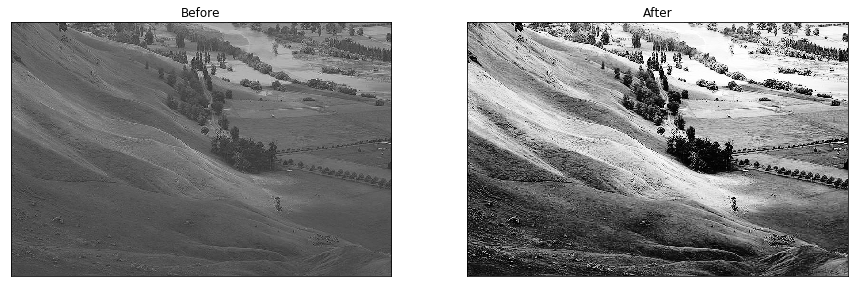

In [17]:
plt.figure(figsize = (15,15))

img2 = cv2.equalizeHist(img) # эквилизация гистограммы

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Before')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2,cmap='gray'),plt.title('After')
plt.xticks([]), plt.yticks([])

## 3. Свёртка

Свёртка это операция, которая превращает набор одних пикселей в другие. Обычно она осущствляется с помощью ядра свёртки, матрицы произвольного размера (обычно 3х3). Центральный элемент такой матрицы называется якорем свёртки. Он применяется к центральному пикселю. 

Работает свёртка очень просто. При вычислении нового значения выбранного пикселя изображения, ядро свёртки прикладывается своим центром к этому пикселю. Далее, вычисляется сумма произведений значений пикселей изображения на значения, накрывшего данный пиксель элемента ядра. Полученная сумма и является новым значением выбранного пикселя.


<center>
<img src="./convolution_schematic.gif">
</center>

Используя матрицы с разными коэффициентами можно получать раные эффекты. 

Попробуем ухудшить качество изображения. В этом нам поможет следующее ядро размера 3 на 3.

$$ K = \frac{1}{9} \cdot \begin{pmatrix}
1 & 1 & 1  \\
1 & 1 & 1  \\         
1 & 1 & 1 
\end{pmatrix} $$

Оно берёт пиксель в каждом квадрате размера 3 на 3 и заменяет его на арифмитическое среднее всех пикселей. Таким образом размерность картинки и её качество падают.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

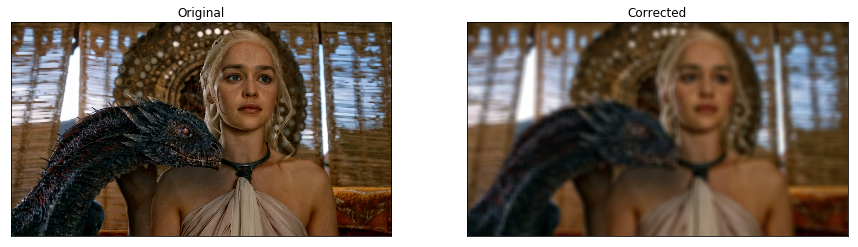

In [23]:
plt.figure(figsize=(15,12))

kernel = np.ones((30,30),np.float32)/900  # Создали в нумпай матрицу из 1/25 размера 5 на 5
dst = cv2.filter2D(img,-1,kernel)      # применили матрицу к нашей картинке 

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([])

Попробуем применить другие ядра. Например, ядро для сглаживания.

$$ \begin{pmatrix}
0.1 & 0.1 & 0.1  \\
0.1 & 0.1 & 0.1 \\         
0.1 & 0.1 & 0.1 
\end{pmatrix} $$

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

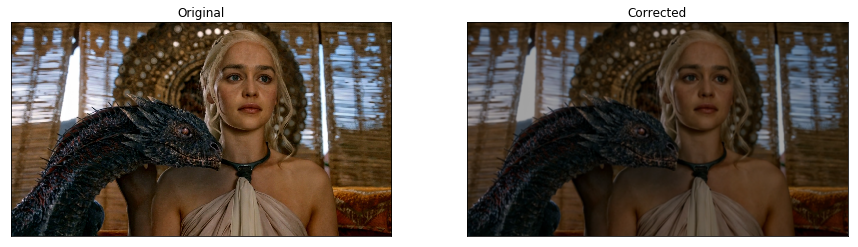

In [26]:
plt.figure(figsize=(15,12))

kernel = 0.01*np.ones((8,8),np.float32)
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([])

Ядро для увеличения чёткости. Обратите внимание на большое значение якоря.

$$ \begin{pmatrix}
0.1 & 0.1 & 0.1  \\
0.1 & 2 & 0.1 \\         
0.1 & 0.1 & 0.1 
\end{pmatrix} $$

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

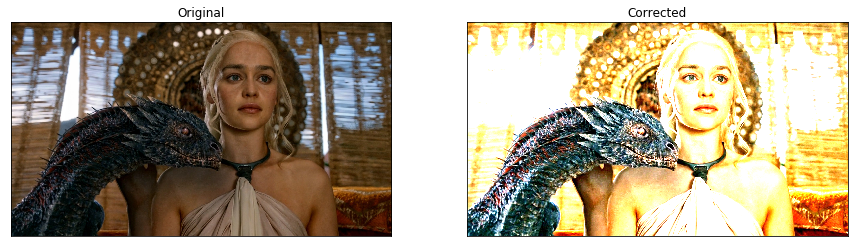

In [29]:
plt.figure(figsize=(15,12))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1]=5
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([])

Забавно, что при повторном применении фильтра для увеличения чёткости, картинка покрывается шумом.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

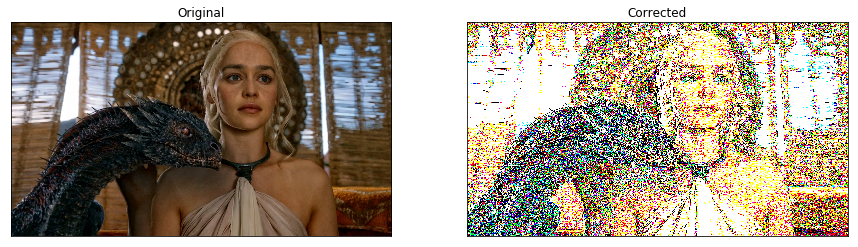

In [30]:
plt.figure(figsize=(15,12))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1]=2
dst = cv2.filter2D(img,-1,kernel)
# Повторяем повторно фильтр 2 раза 
for i in range(20):
    dst = cv2.filter2D(dst,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([])

Гауссовский фильтр хорошо удаляет шум.  Чуствуете иронию? Нормальное распределение пригождается фотошоперам в жизни на ежедневной основе! Правда они даже не знают об этом...

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

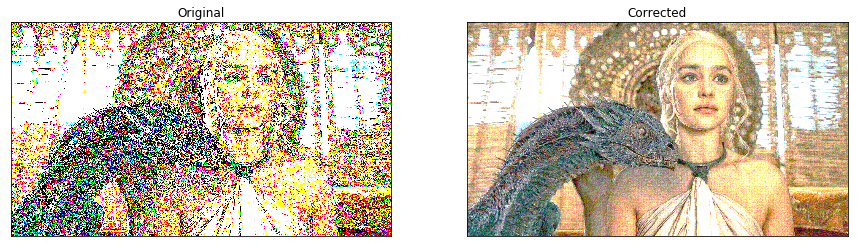

In [31]:
plt.figure(figsize=(15,12))

blur_0 = cv2.GaussianBlur(dst,(5,5),0)
plt.subplot(121),plt.imshow(dst),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur_0),plt.title('Corrected')
plt.xticks([]), plt.yticks([])

Ядра бывают очень разными. Например, вы можете попробовать использовать следующие: 

* Ядро для увеличения яркости. 

$$ \begin{pmatrix}
-0.1 & 0.2 & -0.1  \\
0.2 & 3 & 0.2 \\         
-0.1 & 0.2 & -0.1 
\end{pmatrix} $$

* Ядро для затемнения. 

$$ \begin{pmatrix}
-0.1 & 0.1 & -0.1  \\
 0.1 & 0.5 & 0.1 \\         
-0.1 & 0.1 & -0.1 
\end{pmatrix} $$

* Ядро, которое ничего не делает 

$$ \begin{pmatrix}
0 & 0 & 0  \\
0 & 1 & 0 \\         
0 & 0 & 0 
\end{pmatrix} $$

* Ядро, которое сдвигает картинку

$$ \begin{pmatrix}
1 & 0 & 100  \\
0 & 1 & 50     
\end{pmatrix} $$

* Ядро для пофорота картинки на угол $\phi$ 

$$ \begin{pmatrix}
\cos\phi & -sin\phi  \\
\sin\phi & \cos\phi
\end{pmatrix} $$

* Эрозия и наращивание. Выбираем пиксель с максимальной или минимальной интенсивностью из окрестности.  Наращиваение приводит к увеличению ярких объектов, а эрозия к увеличению тёмных. Наращивание может быть использовано для увеличения бликов ярких изображений. Обычно эрозия имеет округлую форму и выглядит, например, так:

$$ \begin{pmatrix}
0 & 0 & 1 & 0 & 0  \\
0 & 1 & 1 & 1 & 0  \\         
1 & 1 & 1 & 1 & 1  \\
0 & 1 & 1 & 1 & 0  \\        
0 & 0 & 1 & 0 & 0
\end{pmatrix} $$


Абсолютно любая матрица задаёт какое-то преобразование линейного пространства. В данном случае нашей фотографии. При хорошем знании линала, вы можете придумать самые безумные ядра. Попробуйте! 

In [ ]:
# Ваш код для игры в фильтры 

## 3. Углубляемся в свёртку

Попробуйте угадать, что делают следующие два фильтра. 

$$ \begin{pmatrix}
-1 & -1 & -1  \\
0 & 0 & 0 \\         
1 & 1 & 1 
\end{pmatrix}  $$

$$ \begin{pmatrix}
-1 & 0 & 1  \\
-1 & 0 & 1 \\         
-1 & 0 & 1 
\end{pmatrix} $$

Внимание, ответ. Первый фильтр пытается понять насколько резко изменяется яркость картинки по вертикали и находит вертикальные границы. Второй фильтр пытается понять насколько резко изменяется картинка по горизонтали и находит горизонтальные границы. Если просуммировать применение этих фильтров, можно получить чёткое очертание границ картинки. Чем больше в матрицах цифры, тем более резкую разницу находят ядра. 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

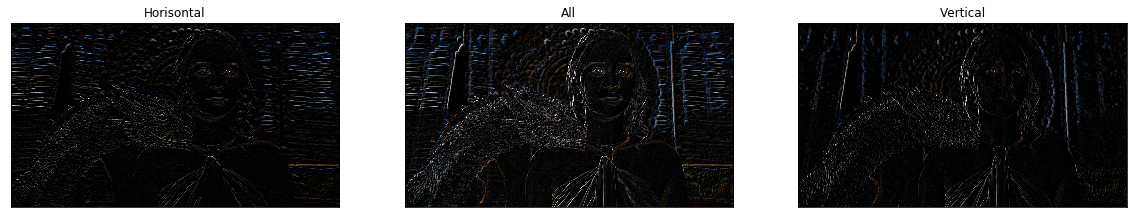

In [34]:
plt.figure(figsize=(20,20))

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(img,-1,kernel1)
dst2 = cv2.filter2D(img,-1,kernel2)
gr1 = cv2.add(dst1,dst2)

plt.subplot(131),plt.imshow(dst1),plt.title('Horisontal')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(gr1),plt.title('All')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst2),plt.title('Vertical')
plt.xticks([]), plt.yticks([])

Если сначала обработать картинку ядром для повышения чёткости, а после применить фильр для поиска границ, они детектируются более чётко. 

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

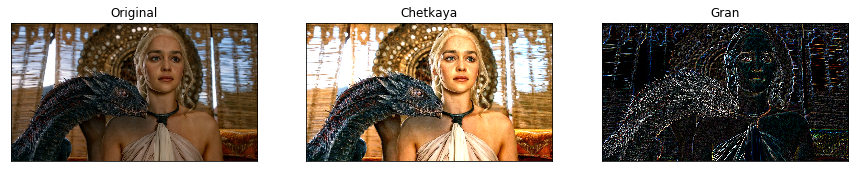

In [33]:
plt.figure(figsize=(15,15))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1]=2
dst = cv2.filter2D(img,-1,kernel)
# Забавно, что при повторном применении этого Ядра картинка покрывается шумом! 
for i in range(3):
    dst = cv2.filter2D(dst,-1,kernel)
    
# Можно почистить картинку от шума 
dst = cv2.GaussianBlur(dst,(5,5),0)

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(dst,-1,kernel1)
dst2 = cv2.filter2D(dst,-1,kernel2)
gr2 = cv2.add(dst1,dst2)

plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(dst),plt.title('Chetkaya')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(gr2),plt.title('Gran')
plt.xticks([]), plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

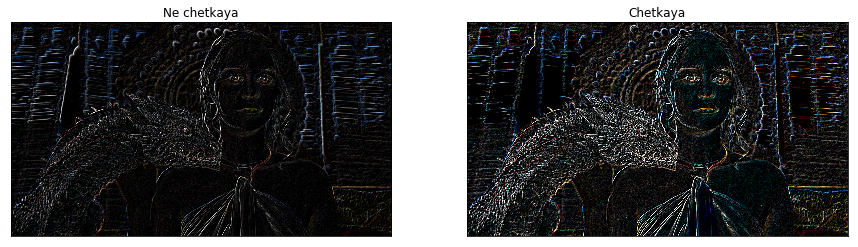

In [35]:
plt.figure(figsize=(15,15))

plt.subplot(121),plt.imshow(gr1),plt.title('Ne chetkaya')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gr2),plt.title('Chetkaya')
plt.xticks([]), plt.yticks([])

Вроде бы граница получилась более чёткой. Внутри пакета есть своя функция для выделения границы. Он работает более агрессивно нежели наше ядро.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

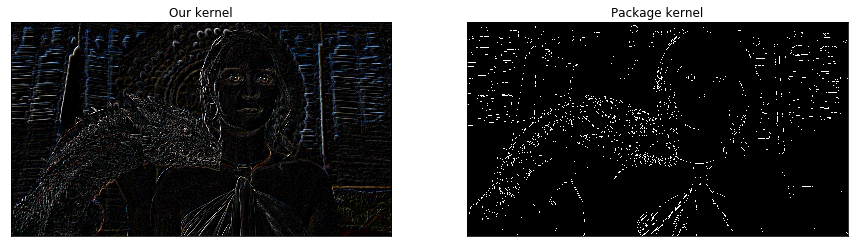

In [36]:
plt.figure(figsize=(15,15))

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(img,-1,kernel1)
dst2 = cv2.filter2D(img,-1,kernel2)
my_gr = cv2.add(dst1,dst2)

# Пакетная функция:
its_gr = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(my_gr),plt.title('Our kernel')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(its_gr,cmap='gray'),plt.title('Package kernel')
plt.xticks([]), plt.yticks([])

Вообще, ядро поиска границы задаёт градиент картики по диагонали и градиент по вертикали. Можно побаловаться с более крутыми градиентами, в том числе диагональными.

$$ \begin{pmatrix}
0 & 1 & 2  \\
-1 & 0 & 1 \\         
-2 & -1 & 0 
\end{pmatrix} $$

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

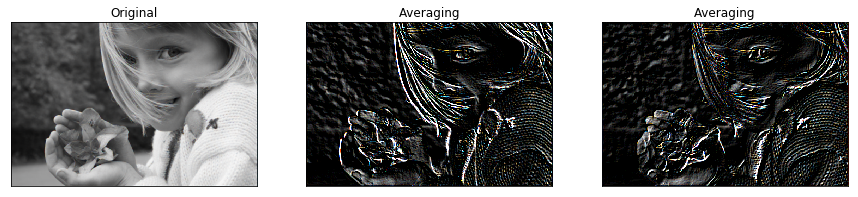

In [37]:
plt.figure(figsize=(15,15))

img = cv2.imread('girl.png',0)
img = cv2.cvtColor(img,cv2.COLOR_BAYER_BG2BGR) # Сделаем картинку серой

kernel1 = 3*np.array([[0,1,2],[-1,0,1],[-2,-1,0]],np.float32)
dst1 = cv2.filter2D(img,-1,kernel1)

kernel2 = 3*np.array([[2,1,0],[1,0,-1],[0,-1,-2]],np.float32)
dst2 = cv2.filter2D(img,-1,kernel2)

plt.subplot(131),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(dst1),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst2),plt.title('Averaging')
plt.xticks([]), plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

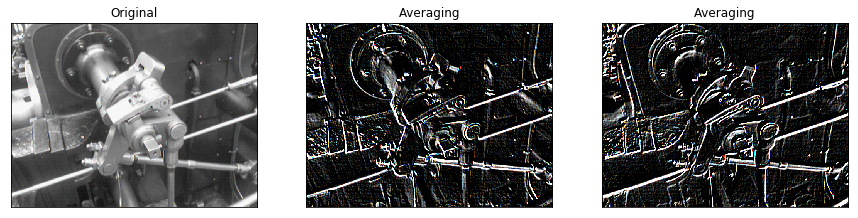

In [38]:
plt.figure(figsize=(15,15))

img = cv2.imread('detal.png',0)
img = cv2.cvtColor(img,cv2.COLOR_BAYER_BG2BGR) # Сделаем картинку серой

kernel1 = 3*np.array([[0,1,2],[-1,0,1],[-2,-1,0]],np.float32)
dst1 = cv2.filter2D(img,-1,kernel1)

kernel2 = 3*np.array([[2,1,0],[1,0,-1],[0,-1,-2]],np.float32)
dst2 = cv2.filter2D(img,-1,kernel2)

plt.subplot(131),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(dst1),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst2),plt.title('Averaging')
plt.xticks([]), plt.yticks([])

Как вы уже догадались, можно придумать фильры не только для поиска границ, но и для поиска других различных закономерностей, которые есть на картинке. 

Представим себе на секунду славный дивный мир, в котором бывают картинки только двух типов: с прямыми слэшами и с обратными (/ \). При этом, эти слэши могут быть нарисованы на картинке где угодно. Пусть у нас есть две картинки. На одной из них слэш нарисован внизу справа, на второй сверху слева. Пройдёмся по нашим картинкам специальным ядром, которое ищет обратные слэши. После свёртки, мы получим на выходе две уменьшившиеся в размерах картинки, в каждой из которых будет фигурировать цифра два, как раз отвечающая за найденный обратный слэш.

<img align="center" src="photo_1.png" height="500" width="500"> 

Если точно такое же ядро натравить на картинку без обратного слэша, оно не выдаст нам на выход никакой двойки. 

<img align="center" src="photo_2.png" height="600" width="600"> 

Получаем простейший классификатор картинок с слэшами. 

1. Проходимся по картинке ядром. 
2. Находим в итоговой матрице максимальный элемент.
3. Если это двойка, на картинке изображён слэш. Если это единица, на картинке обратный слэш.

Обратите внимание, что работа этого классификатора не зависит от того, где именно на картинке находится слэш. Именно так свёрточные нейронные сети и работают с картинками. Конечно же, в реальности закономерности на картинках на порядок сложнее. При этом, мы даже не знаем какими именно могут быть эти закономерности. Для того, чтобы их искать, в нейронную сетку добавляются ядра с неспецифицированными параметрами.

$$ \begin{pmatrix}
w_1 & w_2 & w_3  \\
w_4 & w_5 & w_6 \\         
w_7 & w_8 & w_9 
\end{pmatrix} $$

Слои, на которых находятся эти ядра называются свёрточными. Параметры подбираются в ходе обучения нейронной сети по реальным данным и отражают в себе какие-то закономерности, найденные во время обучения на картинках. Представим, что наша нейронная сеть должна уметь распознавать лица. Добавим в неё несколько свёрточных слоёв. 

Первый слой будет находить простейшие элементы, такие как слэши, прямые чёрточки и извилистые чёрточки. Второй слой будет конструировать из элементов, найденных на первом слое, ещё более сложные штуки. В данном случае окружности и крестики. Третий слой будет конструировать из объектов, найденных на втором слое ещё более сложные объекты. Таким образом, мы, слой за слоем, будем собирать всё более и более сложные объекты до тех пор, пока не дойдём до лица. 

<img align="center" src="photo_3.png" height="600" width="600"> 

Обычно закономерности, которые находит свёрточная сеть сложно интерпретируемы. Тем не менее, мы можем забрать те закономерности, которые нашла нейросетка и использовать их в качестве регрессоров в какой-то более интерпретируемой модели.